# Made With ML
This is a walkthrough notebook for the Made With ML MLOps course.

## Setup

In [7]:
import ray

In [8]:
if ray.is_initialized():
    ray.shutdown()

ray.init()

2023-12-30 11:22:38,361	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.15
Ray version:,2.7.0
Dashboard:,http://127.0.0.1:8265


In [9]:
ray.cluster_resources()

{'node:__internal_head__': 1.0,
 'memory': 37291504436.0,
 'object_store_memory': 18645752217.0,
 'node:192.168.235.68': 1.0,
 'CPU': 8.0}

## Intuition
We'll start by first preparing our data by ingesting it from source and splitting it into training, validation and test data splits.

### Ingestion
Our data could reside in many different places (databases, files, etc.) and exist in different formats (CSV, JSON, Parquet, etc.). For our application, we'll load the data from a CSV file to a Pandas DataFrame using the read_csv function.

In [10]:
import pandas as pd

In [11]:
DATASET_PATH = "../datasets/dataset.csv"
df = pd.read_csv(DATASET_PATH)

df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


> In our data engineering lesson we'll look at how to continually ingest data from more complex sources (ex. data warehouses)

### Splitting
Next, we need to split our training dataset into train and val data splits.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df["tag"].value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

For our multi-class task (where each project has exactly one tag), we want to ensure that the data splits have similar class distributions. We can achieve this by specifying how to stratify the split by using the stratify keyword argument with sklearn's train_test_split() function.

In [14]:
test_size = 0.2
train_df, val_df = train_test_split(
    df,
    stratify=df["tag"],
    test_size=test_size,
    random_state=1234,
)

In [15]:
train_df["tag"].value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

Before we view our validation split's class counts, recall that our validation split is only test_size of the entire dataset. So we need to adjust the value counts so that we can compare it to the training split's class counts.

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>&#x3B1;</mi>
  <mo>&#x2217;</mo>
  <msub>
    <mi>N</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
      <mi>e</mi>
      <mi>s</mi>
      <mi>t</mi>
    </mrow>
  </msub>
  <mo>=</mo>
  <msub>
    <mi>N</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
      <mi>r</mi>
      <mi>a</mi>
      <mi>i</mi>
      <mi>n</mi>
    </mrow>
  </msub>
</math>
<br/>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>N</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
      <mi>r</mi>
      <mi>a</mi>
      <mi>i</mi>
      <mi>n</mi>
    </mrow>
  </msub>
  <mo>=</mo>
  <mn>1</mn>
  <mo>&#x2212;</mo>
  <msub>
    <mi>N</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>t</mi>
      <mi>e</mi>
      <mi>s</mi>
      <mi>t</mi>
    </mrow>
  </msub>
</math>
<br/>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>&#x3B1;</mi>
  <mo>=</mo>
  <mfrac>
    <msub>
      <mi>N</mi>
      <mrow data-mjx-texclass="ORD">
        <mi>t</mi>
        <mi>r</mi>
        <mi>a</mi>
        <mi>i</mi>
        <mi>n</mi>
      </mrow>
    </msub>
    <msub>
      <mi>N</mi>
      <mrow data-mjx-texclass="ORD">
        <mi>t</mi>
        <mi>e</mi>
        <mi>s</mi>
        <mi>t</mi>
      </mrow>
    </msub>
  </mfrac>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mn>1</mn>
      <mo>&#x2212;</mo>
      <msub>
        <mi>N</mi>
        <mrow data-mjx-texclass="ORD">
          <mi>t</mi>
          <mi>e</mi>
          <mi>s</mi>
          <mi>t</mi>
        </mrow>
      </msub>
    </mrow>
    <msub>
      <mi>N</mi>
      <mrow data-mjx-texclass="ORD">
        <mi>t</mi>
        <mi>e</mi>
        <mi>s</mi>
        <mi>t</mi>
      </mrow>
    </msub>
  </mfrac>
</math>

In [16]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1 - test_size) / test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

## Exploratory Data Analysis
Exploratory data analysis (EDA) to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc. depending on how well the problem is defined. For example, if we're unsure how to label or preprocess our data, we can use EDA to figure it out.

We're going to start our project with EDA, a vital (and fun) process that's often misconstrued. Here's how to think about EDA:

- not just to visualize a prescribed set of plots (correlation matrix, etc.).
- goal is to convince yourself that the data you have is sufficient for the task.
- use EDA to answer important questions and to make it easier to extract insight
- not a one time process; as your data grows, you want to revisit EDA to catch distribution shifts, anomalies, etc.

Let's answer a few key questions using EDA.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS, WordCloud
from collections import Counter

sns.set_theme()

### Tag distribution
How many data points do we have per tag? We'll use the Counter class to get counts for all the different tags.

In [16]:
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

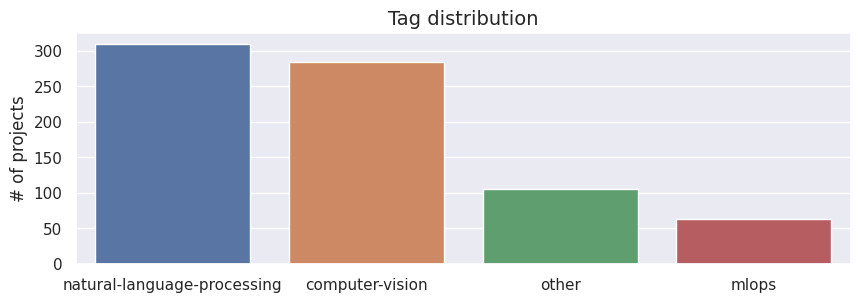

In [20]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
sns.barplot(x=list(tags), y=list(tag_counts))
plt.title("Tag distribution", fontsize=14)
plt.ylabel("# of projects", fontsize=12)
plt.show()

### Wordcloud
Is there enough signal in the title and description that's unique to each tag? This is important to know because we want to verify our initial hypothesis that the project's title and description are high quality features for predicting the tag. And to visualize this, we're going to use a wordcloud. We also use a jupyter widget, which you can view in the notebook, to interactively select a tag and see the wordcloud for that tag.

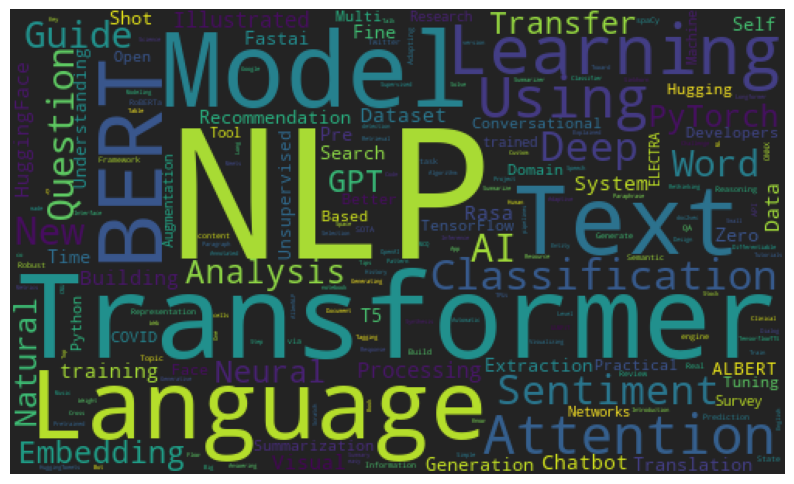

In [25]:
tag = "natural-language-processing"
plt.figure(figsize=(10, 8))
subset = df[df.tag == tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS,
    background_color="#232323",
    collocations=False,
    width=500,
    height=300,
).generate(
    " ".join(text),
)
plt.axis("off")
plt.imshow(cloud)
plt.show()

## Preprocessing
Data preprocessing can be categorized into two types of processes: preparation and transformation. We'll explore common preprocessing techniques and then we'll preprocess our dataset.

### Missing values
First, we'll have to identify the rows with missing values and once we do, there are several approaches to dealing with them.

- omit samples with missing values (if only a small subset are missing it)

In [27]:
# Drop a row (sample) by index
df.drop([4, 10, ...])
# Conditionally drop rows (samples)
df = df[df.value > 0]
# Drop samples with any missing feature
df = df[df.isnull().any(axis=1)]

- omit the entire feature (if too many samples are missing the value)

In [31]:
# Drop a column (feature)
df.drop(["A"], axis=1)

- fill in missing values for features (using domain knowledge, heuristics, etc.)

In [29]:
# Fill in missing values with mean
df.A = df.A.fillna(df.A.mean())

- may not always seem "missing" (ex. 0, null, NA, etc.)

In [ ]:
# Replace zeros to NaNs
import numpy as np

df.A = df.A.replace({"0": np.nan, 0: np.nan})

### Outliers (anomalies)
- craft assumptions about what is a "normal" expected value

In [ ]:
# Ex. Feature value must be within 2 standard deviations
df[np.abs(df.A - df.A.mean()) <= (2 * df.A.std())]

- be careful not to remove important outliers (ex. fraud)
- values may not be outliers when we apply a transformation (ex. power law)
- anomalies can be global (point), contextual (conditional) or collective (individual points are not anomalous and the collective group is an outlier)

### Feature engineering
Feature engineering involves combining features in unique ways to draw out signal.

In [ ]:
# Input
df.C = df.A + df.B

### Cleaning
Cleaning our data involves apply constraints to make it easier for our models to extract signal from the data.

- use domain expertise and EDA
- apply constraints via filters
- ensure data type consistency
- removing data points with certain or null column values
- images (crop, resize, clip, etc.)
  ```python
  # Resize
  import cv2
  dims = (height, width)
  resized_img = cv2.resize(src=img, dsize=dims, interpolation=cv2.INTER_LINEAR)
  ```

- text (lower, stem, lemmatize, regex, etc.)
  ```python
  # Lower case the text
  text = text.lower()
  ```

## Transformations
Transforming the data involves feature encoding and engineering.

## Scaling
- required for models where the scale of the input affects the processes
- learn constructs from train split and apply to other splits (local)
- don't blindly scale features (ex. categorical features)
- standardization: rescale values to mean 0, std 1

In [1]:
# Standardization
import numpy as np

x = np.random.random(4)  # values between 0 and 1
print("x:\n", x)
print(f"mean: {np.mean(x):.2f}, std: {np.std(x):.2f}")
x_standardized = (x - np.mean(x)) / np.std(x)
print("x_standardized:\n", x_standardized)
print(f"mean: {np.mean(x_standardized):.2f}, std: {np.std(x_standardized):.2f}")

x:
 [0.71275343 0.30741669 0.95583968 0.14401743]
mean: 0.53, std: 0.32
x_standardized:
 [ 0.56854587 -0.69250358  1.32481527 -1.20085756]
mean: 0.00, std: 1.00


- min-max: rescale values between a min and max

In [2]:
# Min-max
import numpy as np

x = np.random.random(4)  # values between 0 and 1
print("x:", x)
print(f"min: {x.min():.2f}, max: {x.max():.2f}")
x_scaled = (x - x.min()) / (x.max() - x.min())
print("x_scaled:", x_scaled)
print(f"min: {x_scaled.min():.2f}, max: {x_scaled.max():.2f}")

x: [0.62490355 0.84567893 0.01862124 0.94201203]
min: 0.02, max: 0.94
x_scaled: [0.65658258 0.89567461 0.         1.        ]
min: 0.00, max: 1.00


- binning: convert a continuous feature into categorical using bins

In [3]:
# Binning
import numpy as np

x = np.random.random(4)  # values between 0 and 1
print("x:", x)
bins = np.linspace(0, 1, 5)  # bins between 0 and 1
print("bins:", bins)
binned = np.digitize(x, bins)
print("binned:", binned)

x: [0.57185445 0.73922122 0.2389748  0.50414432]
bins: [0.   0.25 0.5  0.75 1.  ]
binned: [3 3 1 3]


### Encoding
- allows for representing data efficiently (maintains signal) and effectively (learns patterns, ex. one-hot vs embeddings)

- label: unique index for categorical value

  ```python
  # Label encoding
  label_encoder.class_to_index = {
  "attention": 0,
  "autoencoders": 1,
  "convolutional-neural-networks": 2,
  "data-augmentation": 3,
  ... }
  label_encoder.transform(["attention", "data-augmentation"])
  ```

- one-hot: representation as binary vector
  ```python
  # One-hot encoding
  one_hot_encoder.transform(["attention", "data-augmentation"])
  ```
- embeddings: dense representations capable of representing context
  ```python
  # Embeddings
  self.embeddings = nn.Embedding(
      embedding_dim=embedding_dim, num_embeddings=vocab_size)
  x_in = self.embeddings(x_in)
  print (x_in.shape)
  ```

## Extraction
- signal extraction from existing features
- combine existing features
- transfer learning: using a pretrained model as a feature extractor and finetuning on it's results
- autoencoders: learn to encode inputs for compressed knowledge representation
- principle component analysis (PCA): linear dimensionality reduction to project data in a lower dimensional space.

  ```python
  # PCA
  import numpy as np
  from sklearn.decomposition import PCA
  X = np.array([[-1, -1, 3], [-2, -1, 2], [-3, -2, 1]])
  pca = PCA(n_components=2)
  pca.fit(X)
  print (pca.transform(X))
  print (pca.explained_variance_ratio_)
  print (pca.singular_values_)
  ```

- counts (ngram): sparse representation of text as matrix of token counts — useful if feature values have lot's of meaningful, separable signal.

  ```python
  # Counts (ngram)
  from sklearn.feature_extraction.text import CountVectorizer
  y = [
      "acetyl acetone",
      "acetyl chloride",
      "chloride hydroxide",
  ]
  vectorizer = CountVectorizer()
  y = vectorizer.fit_transform(y)
  print (vectorizer.get_feature_names())
  print (y.toarray())
  # 💡 Repeat above with char-level ngram vectorizer
  # vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 3)) # uni, bi and trigrams
  ```

- similarity: similar to count vectorization but based on similarities in tokens

For our application, we'll be implementing a few of these preprocessing steps that are relevant for our dataset.

In [17]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

## Feature engineering
We can combine existing input features to create new meaningful signal for helping the model learn. However, there's usually no simple way to know if certain feature combinations will help or not without empirically experimenting with the different combinations. Here, we could use a project's title and description separately as features but we'll combine them to create one input feature.

In [18]:
# Input
df["text"] = df.title + " " + df.description

## Cleaning
Since we're dealing with text data, we can apply some common text preprocessing operations. Here, we'll be using Python's built-in regular expressions library re and the Natural Language Toolkit nltk.

In [19]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower
    text = text.lower()
    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)
    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    return text

In [21]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text)
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


We'll wrap up our cleaning operation by removing columns (pandas.DataFrame.drop) and rows with null tag values `(pandas.DataFrame.dropna)`.

In [22]:
# DataFrame cleanup
df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # drop cols
df = df.dropna(subset=["tag"])  # drop nulls
df = df[["text", "tag"]]  # rearrange cols
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


## Encoding
We need to encode our data into numerical values so that our models can process them. We'll start by encoding our text labels into unique indices.

In [23]:
# Label to index
tags = train_df.tag.unique().tolist()
num_classes = len(tags)
class_to_index = {tag: i for i, tag in enumerate(tags)}
class_to_index

{'mlops': 0,
 'natural-language-processing': 1,
 'computer-vision': 2,
 'other': 3}

Next, we can use the pandas.Series.map function to map our class_to_index dictionary on our tag column to encode our labels.

In [24]:
# Encode labels
df["tag"] = df["tag"].map(class_to_index)
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,2
1,show infer tell contextual inference creative ...,2
2,awesome graph classification collection import...,3
3,awesome monte carlo tree search curated list m...,3
4,attentionwalk pytorch implementation watch ste...,3


We'll also want to be able to decode our predictions back into text labels. We can do this by creating an index_to_class dictionary and using that to convert encoded labels back into text labels.

In [25]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]


index_to_class = {v: k for k, v in class_to_index.items()}
decode(df.head()["tag"].values, index_to_class=index_to_class)

['computer-vision', 'computer-vision', 'other', 'other', 'other']

## Tokenizer
Next we'll encode our text as well. Instead of using a random dictionary, we'll use a tokenizer that was used for a pretrained LLM (scibert) to tokenize our text. We'll be fine-tuning this exact model later when we train our model.

In [26]:
import numpy as np
from transformers import BertTokenizer

The tokenizer will convert our input text into a list of token ids and a list of attention masks. The token ids are the indices of the tokens in the vocabulary. The attention mask is a binary mask indicating the position of the token indices so that the model can attend to them (and ignore the pad tokens).

In [27]:
# Bert tokenizer
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "Transfer learning with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="np", padding="longest")  # pad to longest item in batch
print("input_ids:", encoded_inputs["input_ids"])
print("attention_mask:", encoded_inputs["attention_mask"])
print(tokenizer.decode(encoded_inputs["input_ids"][0]))

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

input_ids: [[  102  2268  1904   190 29155   168  3267  2998   205   103]]
attention_mask: [[1 1 1 1 1 1 1 1 1 1]]
[CLS] transfer learning with transformers for text classification. [SEP]


We'll wrap our tokenization into a tokenize function that we can use to tokenize batches of our data.

In [28]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["text"].tolist(), return_tensors="np", padding="longest")
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["tag"]))

In [29]:
# Tokenization
tokenize(df.head(1))

{'ids': array([[  102,  2029,  1778,   609,  6446,  4857,  1332,  2399, 13572,
         19125,  1983,  1954,  6240,  3717,  7434,  1262,   537,   201,
          1040,   545,  4714,   103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([2])}

## Best practices
We'll wrap up by combining all of our preprocessing operations into function. This way we can easily apply it to different datasets (training, inference, etc.)

In [30]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df["text"] = df.text.apply(clean_text)  # clean text
    df = df.drop(columns=["id", "created_on", "title", "description"], errors="ignore")  # clean dataframe
    df = df[["text", "tag"]]  # rearrange columns
    df["tag"] = df["tag"].map(class_to_index)  # label encoding
    outputs = tokenize(df)
    return outputs

In [31]:
preprocess(df=train_df, class_to_index=class_to_index)

{'ids': array([[  102,   856,   532, ...,     0,     0,     0],
        [  102,  2177, 29155, ...,     0,     0,     0],
        [  102,  2180,  3241, ...,     0,     0,     0],
        ...,
        [  102,   453,  2068, ...,  5730,   432,   103],
        [  102, 11268,  1782, ...,     0,     0,     0],
        [  102,  1596,   122, ...,     0,     0,     0]]),
 'masks': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 'targets': array([0, 1, 1, 1, 1, 2, 1, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 0, 3, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 3, 3,
        3, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 1, 1, 3, 1, 0,
        1, 2, 2, 2, 3, 2, 3, 2, 3, 2, 1, 1, 3, 3, 3, 1, 1, 2, 3, 0, 1, 1,
        1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 3, 2, 3, 1, 1, 1, 1, 2, 0, 0, 2,
        1, 1, 2, 2, 1, 1, 0, 3, 1